In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *
from pycaret.utils import check_metric
import ipywidgets as widgets
plt.style.use('ggplot')

In [2]:
#!pip install ipywidgets

In [3]:
#!jupyter nbextension enable --py widgetsnbextension

load data

In [4]:
import chardet    
with open("data//takehome_users.csv", "rb") as rawdata:
    result = chardet.detect(rawdata.read())
    charenc = result['encoding']

In [5]:
user = pd.read_csv("data//takehome_users.csv", encoding=charenc)
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [7]:
user_eng = pd.read_csv("data//takehome_user_engagement.csv")
user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [8]:
user_eng.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [9]:
user_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


Estimate the number of visits of each user and evaluate if a user is a adopted user - (a   user   who has   logged   into   the   product   on   three   separate days   in   at   least   one   seven day   period) from user_engagement file.

In [10]:
user_eng['time_stamp'] = pd.to_datetime(user_eng['time_stamp'])

In [11]:
user_eng.sort_values(by = ['user_id','time_stamp'], inplace = True)

In [12]:
#user_eng.sort_values(axis = 'index', by = 'time_stamp', inplace = True)
visits = pd.DataFrame(user_eng.groupby('user_id')['visited'].sum()).reset_index()
visits.columns = ['user_id', 'number_of_visits']
visits.describe()

,user_id,number_of_visits
count,8823.000000,8823.000000
mean,6019.821716,23.565341
std,3464.251001,73.988152
min,1.000000,1.000000
25%,3017.500000,1.000000
50%,6034.000000,1.000000
75%,9029.500000,3.000000
max,12000.000000,606.000000


In [13]:
from tabulate import tabulate
df =pd.DataFrame(visits['number_of_visits'].describe()).T
print(tabulate(df, headers = 'keys', tablefmt = 'grid')) 

+------------------+---------+---------+---------+-------+-------+-------+-------+-------+
|                  |   count |    mean |     std |   min |   25% |   50% |   75% |   max |
+==================+=========+=========+=========+=======+=======+=======+=======+=======+
| number_of_visits |    8823 | 23.5653 | 73.9882 |     1 |     1 |     1 |     3 |   606 |
+------------------+---------+---------+---------+-------+-------+-------+-------+-------+


In [14]:
np.quantile(visits['number_of_visits'], 0.8)

5.0

In [15]:
user_eng.set_index('time_stamp', inplace = True)

In [16]:
num_eng = pd.DataFrame(user_eng.groupby('user_id').rolling(window = '7d')['visited'].sum()).reset_index()

In [17]:
adps = num_eng.groupby('user_id')['visited'].apply(lambda x: 1 if 3 in set(x) else 0) #gives the same output as below
adps = num_eng.groupby('user_id')['visited'].apply(lambda x: 0 if {3,4,5,6}.isdisjoint(set(x)) else 1)
adp_user = pd.DataFrame(adps).reset_index()
adp_user.columns = ['user_id', 'adopted']
user_adp_visits = adp_user.merge(visits, on = 'user_id')
user_adp_visits.head()

,user_id,adopted,number_of_visits
0,1,0,1
1,2,1,14
2,3,0,1
3,4,0,1
4,5,0,1


Text(0.5, 1.0, 'Distribution of number of visits by user adoption')

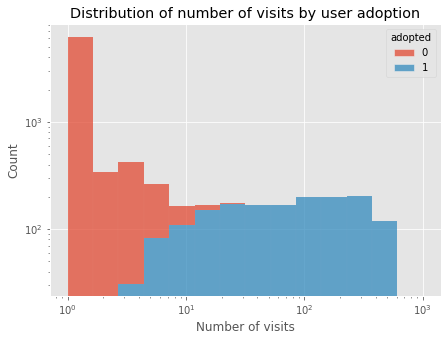

In [18]:
plt.subplots(figsize = (7,5))
ax = sns.histplot(data = user_adp_visits, x = 'number_of_visits' , hue = 'adopted',multiple = 'stack', bins=10**np.linspace(0, 3, 15))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Number of visits")
ax.set_title('Distribution of number of visits by user adoption')

Users with no last_session_creation_time are removed. (Users who have not logged in atleast once after creating an account are removed)

In [19]:
df = user.merge(user_adp_visits, left_on = 'object_id', right_on = 'user_id')
df.drop(columns = ['object_id'], inplace = True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_time               8823 non-null   object 
 1   name                        8823 non-null   object 
 2   email                       8823 non-null   object 
 3   creation_source             8823 non-null   object 
 4   last_session_creation_time  8823 non-null   float64
 5   opted_in_to_mailing_list    8823 non-null   int64  
 6   enabled_for_marketing_drip  8823 non-null   int64  
 7   org_id                      8823 non-null   int64  
 8   invited_by_user_id          4776 non-null   float64
 9   user_id                     8823 non-null   int64  
 10  adopted                     8823 non-null   int64  
 11  number_of_visits            8823 non-null   int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 896.1+ KB


In [21]:
df['last_session_creation_time'] = pd.to_datetime(df['last_session_creation_time'], unit = 's')

In [22]:
df['creation_time'] = pd.to_datetime(df['creation_time'])

'Days since sign up' feature is created from the 'creation time' and 'last session creation time' features. NA's in the 'invited by user id' are replaced by 0. 

In [23]:
df['days_since_sign_up'] = (df['last_session_creation_time'] - df['creation_time']).dt.days
df['days_in_system'] = (pd.to_datetime('2014-06-06 14:59:00') - df['creation_time']).dt.days

In [24]:
df.invited_by_user_id.nunique()

2229

In [25]:
df.describe(include = 'all')

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted,number_of_visits,days_since_sign_up,days_in_system
count,8823,8823,8823,8823,8823,8823.000000,8823.000000,8823.000000,4776.000000,8823.000000,8823.000000,8823.000000,8823.000000,8823.000000
unique,8821,8453,8810,5,8821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2014-02-11 17:57:53,Araujo Gabriela,KerstinNeudorf@gmail.com,ORG_INVITE,2014-06-04 21:21:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,4,2,3188,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2012-05-31 00:43:27,NaN,NaN,NaN,2012-05-31 08:20:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2014-05-30 23:59:19,NaN,NaN,NaN,2014-06-06 14:58:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,0.252295,0.151989,142.572254,5980.495394,6019.821716,0.181571,23.565341,59.222147,322.466621
std,NaN,NaN,NaN,NaN,NaN,0.434354,0.359031,124.176422,3394.211361,3464.251001,0.385512,73.988152,144.172167,215.987725
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000,1.000000,0.000000,6.000000
25%,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,30.000000,3071.000000,3017.500000,0.000000,1.000000,0.000000,127.000000


In [26]:
df['invited_by_user_id'].fillna(0, inplace = True)
df.drop(columns = ['creation_time','name','email','last_session_creation_time', 'invited_by_user_id', 'org_id'], inplace = True)

Modeling - identifying features that predict user adoption

In [27]:
data_tval = df.sample(frac = 0.9,random_state = 42)
data_test = df.drop(data_tval.index)

In [28]:
train_user_id = data_tval['user_id']
test_user_id = data_test['user_id']
data_tval.drop(columns = 'user_id', inplace = True)
data_test.drop(columns = 'user_id', inplace = True)

In [29]:
data_tval.reset_index(inplace = True, drop =True)
data_test.reset_index(inplace = True, drop = True)

In [30]:
exp1 = setup(data = data_tval, target = 'adopted', normalize = True, transformation = True, train_size = 0.75,  categorical_features = ['creation_source', 'opted_in_to_mailing_list','enabled_for_marketing_drip'],silent = True, fold = 5 )

,Description,Value
0,session_id,8474
1,Target,adopted
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(7941, 7)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [31]:
best = compare_models(fold =5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9830,0.9982,0.9521,0.9566,0.9543,0.9438,0.9439,0.3880
lightgbm,Light Gradient Boosting Machine,0.9805,0.9978,0.9467,0.9486,0.9475,0.9355,0.9356,0.1840
ada,Ada Boost Classifier,0.9804,0.9977,0.9476,0.9474,0.9472,0.9352,0.9354,0.2660
catboost,CatBoost Classifier,0.9802,0.9980,0.9430,0.9502,0.9465,0.9343,0.9344,6.3380
xgboost,Extreme Gradient Boosting,0.9800,0.9978,0.9476,0.9451,0.9463,0.9340,0.9341,1.0360
rf,Random Forest Classifier,0.9787,0.9975,0.9358,0.9488,0.9422,0.9291,0.9292,0.7300
svm,SVM - Linear Kernel,0.9777,0.0000,0.9403,0.9415,0.9399,0.9262,0.9269,0.0240
lr,Logistic Regression,0.9772,0.9975,0.9168,0.9586,0.9372,0.9232,0.9236,1.9420
et,Extra Trees Classifier,0.9757,0.9966,0.9214,0.9467,0.9336,0.9187,0.9190,0.5700
dt,Decision Tree Classifier,0.9726,0.9574,0.9331,0.9218,0.9270,0.9102,0.9105,0.0340


In [32]:
gb = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9840,0.9991,0.9638,0.9509,0.9573,0.9475,0.9475
1,0.9798,0.9970,0.9548,0.9378,0.9462,0.9338,0.9338
2,0.9815,0.9977,0.9457,0.9543,0.9500,0.9387,0.9387
3,0.9866,0.9988,0.9593,0.9680,0.9636,0.9554,0.9554
4,0.9832,0.9985,0.9369,0.9720,0.9541,0.9439,0.9441
Mean,0.9830,0.9982,0.9521,0.9566,0.9543,0.9438,0.9439
SD,0.0023,0.0008,0.0097,0.0123,0.0060,0.0074,0.0074


In [33]:
ada = create_model('ada')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9832,0.9980,0.9638,0.9467,0.9552,0.9448,0.9449
1,0.9740,0.9963,0.9593,0.9060,0.9319,0.9158,0.9164
2,0.9790,0.9974,0.9367,0.9495,0.9431,0.9302,0.9302
3,0.9824,0.9984,0.9367,0.9673,0.9517,0.9409,0.9411
4,0.9832,0.9984,0.9414,0.9676,0.9543,0.9441,0.9442
Mean,0.9804,0.9977,0.9476,0.9474,0.9472,0.9352,0.9354
SD,0.0035,0.0008,0.0116,0.0225,0.0088,0.0110,0.0109


In [34]:
ada_t = tune_model(ada)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9832,0.9989,0.9638,0.9467,0.9552,0.9448,0.9449
1,0.9798,0.9972,0.9593,0.9339,0.9464,0.9340,0.9341
2,0.9782,0.9974,0.9367,0.9452,0.9409,0.9275,0.9275
3,0.9840,0.9986,0.9548,0.9591,0.9569,0.9471,0.9471
4,0.9832,0.9984,0.9414,0.9676,0.9543,0.9441,0.9442
Mean,0.9817,0.9981,0.9512,0.9505,0.9507,0.9395,0.9396
SD,0.0023,0.0007,0.0104,0.0117,0.0061,0.0075,0.0075


In [35]:
gb_t = tune_model(gb)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9849,0.9989,0.9638,0.9552,0.9595,0.9502,0.9502
1,0.9840,0.9972,0.9593,0.9550,0.9571,0.9473,0.9473
2,0.9782,0.9974,0.9457,0.9372,0.9414,0.9280,0.9280
3,0.9857,0.9986,0.9593,0.9636,0.9615,0.9527,0.9527
4,0.9849,0.9984,0.9505,0.9679,0.9591,0.9498,0.9499
Mean,0.9835,0.9981,0.9557,0.9558,0.9557,0.9456,0.9456
SD,0.0027,0.0007,0.0066,0.0105,0.0073,0.0090,0.0090


Gradient Boosting Classifier is selected as the best model for prediction based on the F1 score, due to unbalanced class labels for 'adopted'.

In [36]:
best_model = finalize_model(gb)

In [37]:
test_predictions = predict_model(best_model, data = data_test)

In [38]:
f1 = check_metric(test_predictions.adopted, test_predictions.Label, 'F1')
accuracy = check_metric(test_predictions.adopted, test_predictions.Label, 'Accuracy')
print("Accuracy of the model: {}".format(accuracy))
print("F1-score of the model: {}".format(f1))

Accuracy of the model: 0.9853
F1-score of the model: 0.9579


In [39]:
display(evaluate_model(gb))

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

None

The features that most influence future user adoption are the number of times the users have logged into the product and the number of days between sign up and their last session entry.

Other features that can be further looked into are number of visits in the first 60 days after sign up, frequency of the logins (number of logins per week) and stats for time between two logins. 